# Setup & Import Libraries

In [16]:
import os
import pandas as pd
import re
import string
import numpy as np
import warnings
import json

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from unidecode import unidecode
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from pretty_confusion_matrix import pp_matrix


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
warnings.filterwarnings(action="ignore")

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Load Dataset

In [6]:
df = pd.read_csv("Train3Classes.csv", delimiter=';')
df.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


# Exploratory Data Analysis - EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          100000 non-null  int64 
 1   tweet_text  100000 non-null  object
 2   tweet_date  100000 non-null  object
 3   sentiment   100000 non-null  int64 
 4   query_used  100000 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.8+ MB


In [ ]:
df.describe()

,id,sentiment
count,1.000000e+05,100000.000000
mean,1.045736e+18,1.000000
std,4.262747e+15,0.816497
min,1.027374e+18,0.000000
25%,1.045369e+18,0.000000
50%,1.046820e+18,1.000000
75%,1.049106e+18,2.000000
max,1.053355e+18,2.000000


In [ ]:
df["sentiment"].value_counts() # Basically the dataset is balanced

1    33334
0    33333
2    33333
Name: sentiment, dtype: int64

In [ ]:
def plot_class_distribution(dataframe):
    fig = plt.figure(figsize=(10, 5))
    distribution = dataframe["sentiment"].map({0: "Negative",
                                                         1: "Positive",
                                                         2: "Neutra"}).value_counts()
    # distribution = dataframe["sentiment"].value_counts()
    ax = distribution.plot(kind="bar", title="Class Distribution (Samples)", cmap="Spectral")
    ax.set_xlabel("Sentiment")
    ax.set_ylabel("Samples")
    plt.show()

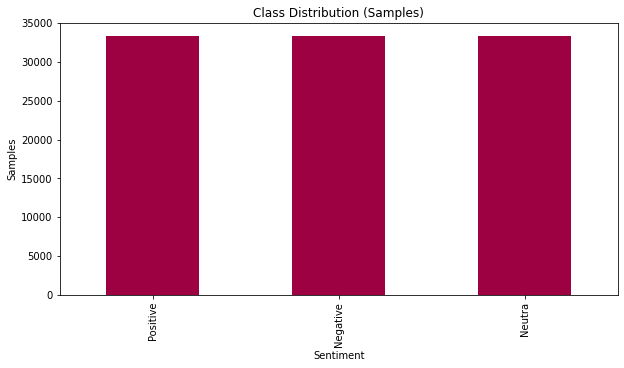

In [ ]:
plot_class_distribution(df)

In [ ]:
def plot_query_distribution(dataframe):
    fig = plt.figure(figsize=(10, 5))
    distribution = dataframe["query_used"].value_counts()
    ax = distribution.plot(kind="bar", title="Class Distribution (Samples)", cmap="Spectral")
    ax.set_xlabel("Query Used Collect")
    ax.set_ylabel("Samples")
    plt.show()

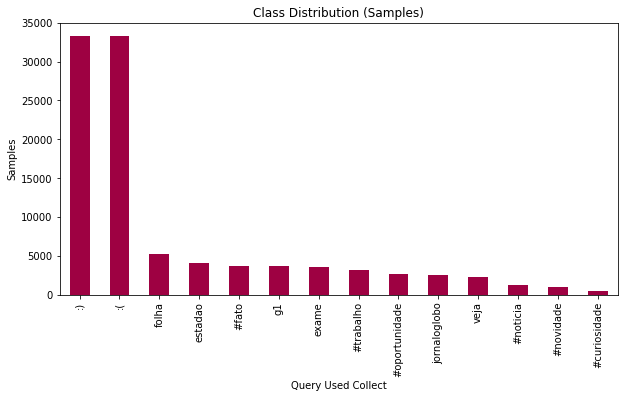

In [ ]:
plot_query_distribution(df)

**Check some samples**

In [ ]:
print(f"Sample: {df['tweet_text'].to_list()[0]}")

Sample: @Laranjito76 A pessoa certa para isso seria o vale e azevedo :)


# Preprocessing

**Split the data input and target**

In [13]:
data = df["tweet_text"].values
target = df["sentiment"].values

## Simple Feature Extraction

**Remove urls, rt and hashtag. Get the frequency of vocabulary**

In [20]:
def process_tweet(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('portuguese')

    tweet = re.sub(r'\$\w*', '', tweet)

    tweet = re.sub(r'^RT[\s]+', '', tweet)

    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)

    tweet = re.sub(r'#', '', tweet)

    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  
                word not in string.punctuation):  
            
            stem_word = stemmer.stem(word)  
            tweets_clean.append(stem_word)

    return tweets_clean


def build_freqs(tweets, ys):
    yslist = np.squeeze(ys).tolist()

    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [ ]:
freq = build_freqs(data, target)

**Simple feature extraction**

In [ ]:
def extract_features_utils(tweet, freqs):
    word_l = process_tweet(tweet)
    
    x = np.zeros((1, 4)) 
    
    x[0,0] = 1 

    for word in word_l:
        x[0,1] += freqs.get((word, 1.0),0)
        x[0,2] += freqs.get((word, 0.0),0)
        x[0,3] += freqs.get((word, 2.0),0)

    assert(x.shape == (1, 4))
    return x

def extract_features(data, freq):
    X = np.zeros((len(data), 4))
    for i in range(len(data)):
        X[i, :]= extract_features_utils(data[i], freq)

    return X

In [ ]:
tmp1 = extract_features_utils(data[0], freq)
print(f"Feature extraction example: {tmp1}")

Feature extraction example: [[1.0000e+00 2.8031e+04 1.0090e+03 6.1800e+02]]


In [ ]:
features = extract_features(data, freq)

In [ ]:
print(f"N of samples: {len(data)}, N of features: {features.shape[1]}")

N of samples: 100000, N of features: 4


## Using TF-IDF (Term Frequency-Inverse Document Frequency)

In [22]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, *_):
        data = pd.Series(X) if not isinstance(X, pd.Series) else X
        data = data.apply(self._preprocess_text)
        return data

    def _preprocess_text(self, text):
        stemmer = PorterStemmer()
        stopwords_english = stopwords.words('portuguese')

        text = re.sub(r'\$\w*', '', text)

        text = re.sub(r'^RT[\s]+', '', text)

        text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

        pre_text = re.sub(r'#', '', text)
        return pre_text

# Split into train

In [14]:
# X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.1,
#                                                   random_state=42)
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.1,
                                                  random_state=42)

In [15]:
print(f"Sample of train: {len(X_train)}, Samples of validation: {len(X_val)}")

Sample of train: 90000, Samples of validation: 10000


# Build and Train a Logistic Regression Pipeline

In [ ]:
pipeline = Pipeline([
    ("clf_lr", LogisticRegression(random_state=42,))
])
grid_params = {
    "clf_lr__C": [50, 100, 150, 200, 300],
}

In [ ]:
clf = GridSearchCV(pipeline, grid_params)

clf.fit(X_train, y_train)
print(f"Best Score: {clf.best_score_}")
print(f"Best Params: {clf.best_params_}")

Best Score: 0.9797555555555556
Best Params: {'clf_lr__C': 100}


In [25]:
pipeline = Pipeline([
    ("normalize", TextPreprocessor()),
    ("features", TfidfVectorizer(
        ngram_range=(1,2), analyzer="word",
        sublinear_tf=True, max_features=3_000,
        max_df=0.9, preprocessor=None
    )),
    ('clf_lr', LogisticRegression(random_state=42,))
])

In [26]:
grid_params = {
    "clf_lr__C": [1, 100],
}
clf = GridSearchCV(pipeline, grid_params)

clf.fit(X_train, y_train)
print(f"Best Score: {clf.best_score_}")
print(f"Best Params: {clf.best_params_}")

Best Score: 0.8010333333333334
Best Params: {'clf_lr__C': 1}


In [ ]:
clf_lr = LogisticRegression(random_state=42, C=100)
clf_lr.fit(X_train, y_train)

LogisticRegression(C=100, random_state=42)

# Evaluate the Model

In [27]:
# y_pred = clf_lr.predict(X_val)
y_pred = clf.predict(X_val)

In [28]:
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")

Accuracy: 0.8111


**Save model**

In [ ]:
# clf_lr.intercept_

In [ ]:
model_param = {
    "coef": list(clf_lr.coef_.tolist()),
    "intercept": list(clf_lr.intercept_.tolist())
}

In [ ]:
def save_parameters(model_param: dict, data_path: str):
    json_object = json.dumps(model_param, indent=4)
    with open(data_path, 'w') as outfile:
        outfile.write(json_object)

In [ ]:
save_parameters(model_param, "model_param.json")

**Plot Confusion Matrix**

In [30]:
def plot_cm(cm):
    label_names = ["Negative", "Positive", "Neutral"]
    cmap = 'PuRd'
    df_cm = pd.DataFrame(cm, index=label_names, columns=label_names)

    pp_matrix(df_cm, cmap=cmap)
    plt.show()

In [31]:
cm = confusion_matrix(y_val, y_pred)

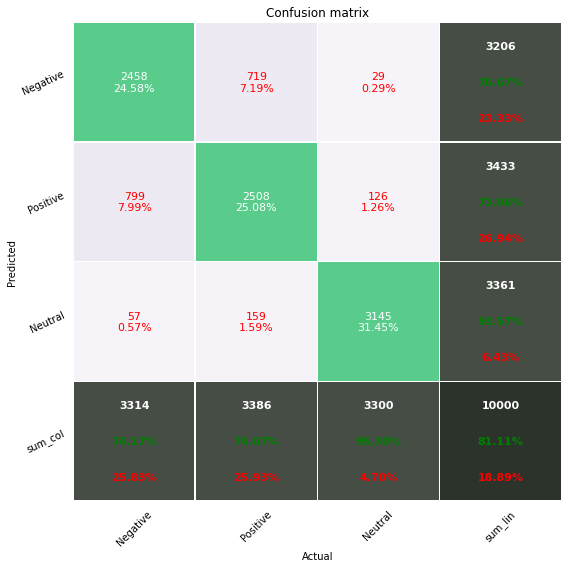

In [35]:
plot_cm(cm)

# Predict a custom tweet

In [47]:
def predict_custom_messages(custom_messages: str):
    y_hat = clf.predict([custom_messages])
    if (y_hat == 0):
        print("Negative sentiment")
    elif (y_hat == 1):
        print("Positive sentiment")
    else: 
        print("Neutral sentiment")

In [49]:
predict_custom_messages("É muito bom ser cliente de vocês")

Positive sentiment


In [50]:
predict_custom_messages("Horrível este agente, não presta pra nada!")

Negative sentiment


In [51]:
predict_custom_messages("vamos a luta!")

Positive sentiment


In [52]:
predict_custom_messages("Entender função de loss, como é feito o agrupamento online, formas de classificação.")

Neutral sentiment
